# Grouping

Chapter 9 in Python for Data Analysis demonstrates a variety of methods to analyze data via data aggregation and grouping operations. Those are the focus of this session.  Our overall goal for this session is to do Exploratory Data Analysis, which is essentially looking at and probing our data to learn about the patterns we can discover in them.  Often this can generate a better understanding of problems in the data, as well as revealing relationships that might be worth exploring in more depth.


For this exercise, we will use 2010 US Census data, for all census tracts in Kentucky.  A good starting point for any kind of Census data is the American Fact Finder: 

https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml

The Census Bureau produces several products, the most famous of which is the decennial census, which as its name implies, is a true Census.  There are a limited number of data fields for the whole population (or at least those that the Census workers are able to reach, which is pretty good).  The Census has other products that are surveys, such as the American Community Survey (ACS) which asks more detailed questions on an annual basis from a 1% sample of households.  

In this case, we are working with file DP-1: Profile of General Population and Housing Characteristics: 2010, which is also a part of something called Summary File 1 (SF-1).  It is for the 100% sample.  A data dictionary for selected fields is below.  

In [2]:
import numpy as np

In [3]:
import pandas as pd

# skip the second row, which contains descriptions
sf1 = pd.read_csv('data/DEC_10_SF1_combined.csv', skiprows=[1])

# make the tract, county and state separate
sf1['tract'] = sf1['GEO.display-label'].apply(lambda x: x.split(sep=',')[0])
sf1['county'] = sf1['GEO.display-label'].apply(lambda x: x.split(sep=',')[1])
sf1['state'] = sf1['GEO.display-label'].apply(lambda x: x.split(sep=',')[2])

# compute some derived fields
sf1['pct_rent'] = sf1['H4-D004'] / sf1['H4-D001'] * 100
sf1['pct_black'] = sf1['P3-D003'] / sf1['P3-D001'] * 100
sf1['pct_asian'] = sf1['P3-D005'] / sf1['P3-D001'] * 100
sf1['pct_white'] = sf1['P3-D002'] / sf1['P3-D001'] * 100
sf1['pct_hisp'] = sf1['P4-D003'] / sf1['P4-D001'] * 100
sf1['pct_vacant'] = sf1['H5-D001'] / sf1['H1-D001'] * 100
sf1[:5]

,GEO.id,GEO.id2,GEO.display-label,P1-D001,P3-D001,P3-D002,P3-D003,P3-D004,P3-D005,P3-D006,...,H5-D008,tract,county,state,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant
0,1400000US21001970100,21001970100,"Census Tract 9701, Adair County, Kentucky",1727,1727,1683,14,1,0,1,...,60,Census Tract 9701,Adair County,Kentucky,17.411402,0.810654,0.000000,97.452229,2.142444,16.794872
1,1400000US21001970200,21001970200,"Census Tract 9702, Adair County, Kentucky",1722,1722,1635,41,5,0,0,...,35,Census Tract 9702,Adair County,Kentucky,19.252874,2.380952,0.000000,94.947735,2.613240,25.161290
2,1400000US21001970300,21001970300,"Census Tract 9703, Adair County, Kentucky",3016,3016,2944,6,11,8,0,...,106,Census Tract 9703,Adair County,Kentucky,20.521173,0.198939,0.265252,97.612732,1.856764,15.193370
3,1400000US21001970401,21001970401,"Census Tract 9704.01, Adair County, Kentucky",4070,4070,3716,237,1,16,1,...,109,Census Tract 9704.01,Adair County,Kentucky,37.215909,5.823096,0.393120,91.302211,1.547912,10.795743
4,1400000US21001970402,21001970402,"Census Tract 9704.02, Adair County, Kentucky",4261,4261,3950,180,16,16,3,...,70,Census Tract 9704.02,Adair County,Kentucky,30.911681,4.224360,0.375499,92.701244,1.900962,11.642542


## Groupby and Aggregation Operations

Groupby is a powerful method in pandas that follows the split-apply-combine approach to data.  As shown in Figure 9-1 in the context of a sum operation, the data is first split into groups that share the same key values.  Then an operation, in this case a sum, is applied to each group.  Then the results are combined.

The built-in aggregation methods available for groupby operations include:
* count
* sum
* mean
* median
* std, var
* min, max
* first, last

You can also apply your own functions as aggregation methods.

![Groupby Operations](groupby.png "Groupby")

Let's apply this approach to computing total population in each county in our dataset.  We can do this in two steps to help explain what is happening.  First we create a groupby object, using county codes to group all the census blocks in sf1 into groups that share the same county code.

In [4]:
grouped = sf1['P1-D001'].groupby(sf1['county'])
grouped

Now that we have this grouping object that represents the **split** part of the workflow in the figure above, we can **apply** operations and **combine** the results using methods like sum:

In [5]:
grouped.sum().head()

county
 Adair County       18656
 Allen County       19956
 Anderson County    21421
 Ballard County      8249
 Barren County      42173
Name: P1-D001, dtype: int64

We might want to capture the result in a DataFrame if we want to use it in other processing, like merging the results to the original DataFrame.

In [6]:
county_pop = sf1['P1-D001'].groupby(sf1['county']).sum().to_frame(name='county_population')
county_pop.head()

,county_population
county,
Adair County,18656
Allen County,19956
Anderson County,21421
Ballard County,8249
Barren County,42173


Here we merge the county total population with sf1 and create a new DataFrame.

In [7]:
sf2 = pd.merge(sf1,county_pop, left_on='county', right_index=True)
sf2[:5]

,GEO.id,GEO.id2,GEO.display-label,P1-D001,P3-D001,P3-D002,P3-D003,P3-D004,P3-D005,P3-D006,...,tract,county,state,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant,county_population
0,1400000US21001970100,21001970100,"Census Tract 9701, Adair County, Kentucky",1727,1727,1683,14,1,0,1,...,Census Tract 9701,Adair County,Kentucky,17.411402,0.810654,0.000000,97.452229,2.142444,16.794872,18656
1,1400000US21001970200,21001970200,"Census Tract 9702, Adair County, Kentucky",1722,1722,1635,41,5,0,0,...,Census Tract 9702,Adair County,Kentucky,19.252874,2.380952,0.000000,94.947735,2.613240,25.161290,18656
2,1400000US21001970300,21001970300,"Census Tract 9703, Adair County, Kentucky",3016,3016,2944,6,11,8,0,...,Census Tract 9703,Adair County,Kentucky,20.521173,0.198939,0.265252,97.612732,1.856764,15.193370,18656
3,1400000US21001970401,21001970401,"Census Tract 9704.01, Adair County, Kentucky",4070,4070,3716,237,1,16,1,...,Census Tract 9704.01,Adair County,Kentucky,37.215909,5.823096,0.393120,91.302211,1.547912,10.795743,18656
4,1400000US21001970402,21001970402,"Census Tract 9704.02, Adair County, Kentucky",4261,4261,3950,180,16,16,3,...,Census Tract 9704.02,Adair County,Kentucky,30.911681,4.224360,0.375499,92.701244,1.900962,11.642542,18656


In [8]:
sf2['pop_pct_in_tract'] = sf2['P1-D001']/sf2['county_population']*100

In [9]:
sf2.head()

,GEO.id,GEO.id2,GEO.display-label,P1-D001,P3-D001,P3-D002,P3-D003,P3-D004,P3-D005,P3-D006,...,county,state,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant,county_population,pop_pct_in_tract
0,1400000US21001970100,21001970100,"Census Tract 9701, Adair County, Kentucky",1727,1727,1683,14,1,0,1,...,Adair County,Kentucky,17.411402,0.810654,0.000000,97.452229,2.142444,16.794872,18656,9.257075
1,1400000US21001970200,21001970200,"Census Tract 9702, Adair County, Kentucky",1722,1722,1635,41,5,0,0,...,Adair County,Kentucky,19.252874,2.380952,0.000000,94.947735,2.613240,25.161290,18656,9.230274
2,1400000US21001970300,21001970300,"Census Tract 9703, Adair County, Kentucky",3016,3016,2944,6,11,8,0,...,Adair County,Kentucky,20.521173,0.198939,0.265252,97.612732,1.856764,15.193370,18656,16.166381
3,1400000US21001970401,21001970401,"Census Tract 9704.01, Adair County, Kentucky",4070,4070,3716,237,1,16,1,...,Adair County,Kentucky,37.215909,5.823096,0.393120,91.302211,1.547912,10.795743,18656,21.816038
4,1400000US21001970402,21001970402,"Census Tract 9704.02, Adair County, Kentucky",4261,4261,3950,180,16,16,3,...,Adair County,Kentucky,30.911681,4.224360,0.375499,92.701244,1.900962,11.642542,18656,22.839837


In [10]:
sf2['pop_pct_in_tract'].sum()/100

120.00000000000001

## Transforming Data with Groupby

In some cases you may want to apply a function to your data, by group.  An example would be to normalize a column by a mean of each group.  Say we wanted to subtract the mean population density of each county from the population density of each census block. We could write a function to subtract the mean from each value, and then use the transform operation to apply this to each group:

In [11]:
def demean(arr):
    return arr - arr.mean()
#demean centers everything to zero

Now we can apply this tranformation to columns in our dataframe.  As examples, let's 'demean' the pct_black and pct_rent columns, subtracting the county-wide mean of these values from the tract-specific values, so that the result is transformed to have a mean of zero within each county.

To check the results, we print the means per county, then the original values for the first 5 rows, then the transformed results.  The transformed results we should be able to calculate by subtracting the appropriate county mean from the tract value.

In [15]:
normalized = sf1[['pct_black', 'pct_rent']].groupby(sf1['county']).transform(demean)
print(sf1[['pct_black', 'pct_rent']].groupby(sf1['county']).mean())
print(sf1[['county','pct_black', 'pct_rent']][:5])
print(normalized[:5])

                      pct_black   pct_rent
county                                    
 Adair County          2.104384  22.886621
 Allen County          0.716792  22.312658
 Anderson County       1.419188  20.908477
 Ballard County        2.690326  21.350937
 Barren County         3.385357  29.982273
 Bath County           1.719977  23.865098
 Bell County           2.017470  32.080953
 Boone County          2.362180  24.779530
 Bourbon County        4.863221  33.604963
 Boyd County           2.690429  33.766804
 Boyle County          7.501400  33.987453
 Bracken County        0.319829  24.755274
 Breathitt County      0.291431  20.408091
 Breckinridge County   1.492590  18.524204
 Bullitt County        0.582663  18.852640
 Butler County         0.293354  20.702463
 Caldwell County       4.372987  22.422207
 Calloway County       4.146136  37.944503
 Campbell County       3.106286  34.861471
 Carlisle County       0.752688  17.877812
 Carroll County        1.184510  31.659932
 Carter Cou

We can merge these transformed results on to the original DataFrame, and check the means of the original variables and the tranformed ones.  The transformed ones should be arbitrarily close to zero.

In [16]:
sf2 = pd.merge(sf1,normalized, left_index=True, right_index=True)

sf2.groupby('county')[['pct_black_x', 'pct_black_y', 'pct_rent_x', 'pct_rent_y']].mean().head()
#notice the infinitely small numbers for the y columns.  The normalized values center to zero

,pct_black_x,pct_black_y,pct_rent_x,pct_rent_y
county,,,,
Adair County,2.104384,-2.854859e-16,22.886621,-2.030122e-15
Allen County,0.716792,-5.551115e-17,22.312658,-3.256654e-15
Anderson County,1.419188,8.881784e-17,20.908477,7.105427e-16
Ballard County,2.690326,1.480297e-16,21.350937,0.000000e+00
Barren County,3.385357,0.000000e+00,29.982273,4.618528e-15


Apply is a method we have learned previously, which allows us to apply a function to each row in a DataFrame.  We can also combine apply with groupby to apply functions based on group membership.  For example, the function 'top' sorts an array and selects the top n rows from it.  We provide some defaults for the arguments of how many rows, and the column to use for the selection:

In [17]:
def top(df, n=5, column='pct_rent'):
    return df.sort_values(by=column, ascending=False).head(n)

Using this on the full dataset and setting the number of rows and the column to get the top values for, in this case using pct_rent to override the default argument, we get the top 10 tracts in the region in terms of percentage rental.

In [18]:
top(sf1, n=10, column='pct_rent')

,GEO.id,GEO.id2,GEO.display-label,P1-D001,P3-D001,P3-D002,P3-D003,P3-D004,P3-D005,P3-D006,...,H5-D008,tract,county,state,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant
255,1400000US21061980100,21061980100,"Census Tract 9801, Edmonson County, Kentucky",8,8,8,0,0,0,0,...,0,Census Tract 9801,Edmonson County,Kentucky,100.000000,0.000000,0.000000,100.000000,0.000000,0.000000
508,1400000US21111003000,21111003000,"Census Tract 30, Jefferson County, Kentucky",3565,3565,258,3187,15,1,16,...,7,Census Tract 30,Jefferson County,Kentucky,99.768697,89.396914,0.028050,7.237027,1.290323,7.883523
200,1400000US21047201501,21047201501,"Census Tract 2015.01, Christian County, Kentucky",5315,5315,3580,982,64,47,81,...,8,Census Tract 2015.01,Christian County,Kentucky,99.698568,18.476011,0.884290,67.356538,14.995296,7.072829
415,1400000US21093000202,21093000202,"Census Tract 2.02, Hardin County, Kentucky",4514,4514,3053,863,45,78,20,...,21,Census Tract 2.02,Hardin County,Kentucky,99.679230,19.118299,1.727957,67.634027,14.842712,5.957768
872,1400000US21163970200,21163970200,"Census Tract 9702, Meade County, Kentucky",2683,2683,1916,414,41,30,15,...,161,Census Tract 9702,Meade County,Kentucky,99.270960,15.430488,1.118151,71.412598,15.803205,32.980456
201,1400000US21047201502,21047201502,"Census Tract 2015.02, Christian County, Kentucky",4527,4527,3055,740,45,61,84,...,6,Census Tract 2015.02,Christian County,Kentucky,98.896435,16.346366,1.347471,67.483985,18.003093,6.507937
414,1400000US21093000201,21093000201,"Census Tract 2.01, Hardin County, Kentucky",1409,1409,1150,153,9,19,6,...,60,Census Tract 2.01,Hardin County,Kentucky,98.620690,10.858765,1.348474,81.618169,10.432931,28.571429
833,1400000US21151010500,21151010500,"Census Tract 105, Madison County, Kentucky",4182,4182,3699,330,11,56,6,...,7,Census Tract 105,Madison County,Kentucky,96.078431,7.890961,1.339072,88.450502,1.673840,8.602151
270,1400000US21067000801,21067000801,"Census Tract 8.01, Fayette County, Kentucky",4094,4094,3255,385,6,356,2,...,13,Census Tract 8.01,Fayette County,Kentucky,95.617530,9.404006,8.695652,79.506595,2.002931,36.775819
142,1400000US21037050100,21037050100,"Census Tract 501, Campbell County, Kentucky",1733,1733,1197,368,1,43,0,...,11,Census Tract 501,Campbell County,Kentucky,94.527363,21.234853,2.481246,69.070975,3.693018,7.903780


Below we apply this with groupby and use the defaults for n and column, and it applies the function within each county and concatenates the results, producing the top 5 blocks on pop_sqmi for each county in the region.

In [19]:
sf1.groupby('county').apply(top).head()

GEO.id      GEO.id2  \
county                                               
 Adair County 3  1400000US21001970401  21001970401   
              4  1400000US21001970402  21001970402   
              2  1400000US21001970300  21001970300   
              1  1400000US21001970200  21001970200   
              5  1400000US21001970500  21001970500   

                                            GEO.display-label  P1-D001  \
county                                                                   
 Adair County 3  Census Tract 9704.01, Adair County, Kentucky     4070   
              4  Census Tract 9704.02, Adair County, Kentucky     4261   
              2     Census Tract 9703, Adair County, Kentucky     3016   
              1     Census Tract 9702, Adair County, Kentucky     1722   
              5     Census Tract 9705, Adair County, Kentucky     2457   

                 P3-D001  P3-D002  P3-D003  P3-D004  P3-D005  P3-D006  \
county                                                                  
 Adair County 3     4070     3716      237        1       16        1   
              4     4261     3950      180       16       16        3   
              2     3016     2944        6       11        8        0   
              1     1722     1635       41        5        0        0   
              5     2457     2402       16        2        5        0   

                    ...      H5-D008                 tract         county  \
county              ...                                                     
 Adair County 3     ...          109  Census Tract 9704.01   Adair County   
              4     ...           70  Census Tract 9704.02   Adair County   
              2     ...          106     Census Tract 9703   Adair County   
              1     ...           35     Census Tract 9702   Adair County   
              5     ...          104     Census Tract 9705   Adair County   

                     state   pct_rent  pct_black  pct_asian  pct_white  \
county                                                                   
 Adair County 3   Kentucky  37.215909   5.823096   0.393120  91.302211   
              4   Kentucky  30.911681   4.224360   0.375499  92.701244   
              2   Kentucky  20.521173   0.198939   0.265252  97.612732   
              1   Kentucky  19.252874   2.380952   0.000000  94.947735   
              5   Kentucky  17.972832   0.651201   0.203500  97.761498   

                 pct_hisp  pct_vacant  
county                                 
 Adair County 3  1.547912   10.795743  
              4  1.900962   11.642542  
              2  1.856764   15.193370  
              1  2.613240   25.161290  
              5  0.773301   17.641997  

[5 rows x 40 columns]

Here we pass arguments to the function to set n and the column to select the top value from.

In [20]:
sf1.groupby('county').apply(top, n=1, column='P1-D001').head()

,,GEO.id,GEO.id2,GEO.display-label,P1-D001,P3-D001,P3-D002,P3-D003,P3-D004,P3-D005,P3-D006,...,H5-D008,tract,county,state,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant
county,,,,,,,,,,,,,,,,,,,,,,
Adair County,4,1400000US21001970402,21001970402,"Census Tract 9704.02, Adair County, Kentucky",4261,4261,3950,180,16,16,3,...,70,Census Tract 9704.02,Adair County,Kentucky,30.911681,4.224360,0.375499,92.701244,1.900962,11.642542
Allen County,9,1400000US21003920300,21003920300,"Census Tract 9203, Allen County, Kentucky",4685,4685,4473,83,19,12,0,...,86,Census Tract 9203,Allen County,Kentucky,34.676186,1.771612,0.256137,95.474920,1.173959,9.254975
Anderson County,13,1400000US21005950100,21005950100,"Census Tract 9501, Anderson County, Kentucky",8164,8164,7647,292,5,38,3,...,103,Census Tract 9501,Anderson County,Kentucky,26.186684,3.576678,0.465458,93.667320,1.641352,8.081991
Ballard County,18,1400000US21007950100,21007950100,"Census Tract 9501, Ballard County, Kentucky",4259,4259,4024,145,8,11,0,...,132,Census Tract 9501,Ballard County,Kentucky,22.140011,3.404555,0.258277,94.482273,0.986147,11.664153
Barren County,26,1400000US21009950600,21009950600,"Census Tract 9506, Barren County, Kentucky",5937,5937,5331,299,11,40,10,...,95,Census Tract 9506,Barren County,Kentucky,44.142343,5.036214,0.673741,89.792825,2.779181,11.500354


## Exploring Correlations in the Data

Pandas provides simple ways of computing correlation coefficients among the columns in your DataFrame.  If you use corr() on a full DF, it will produce a large correlation table.  A bit hard to navigate and you mostly would not be interested in some of these results.

In [21]:
sf1.corr()

,GEO.id2,P1-D001,P3-D001,P3-D002,P3-D003,P3-D004,P3-D005,P3-D006,P3-D007,P3-D008,...,H5-D005,H5-D006,H5-D007,H5-D008,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant
GEO.id2,1.000000,0.049408,0.049408,0.063873,-0.024147,0.001960,-0.048639,-0.031018,-0.020234,-0.045010,...,0.077670,0.076772,0.010594,0.119563,-0.061820,-0.033330,-0.058690,0.045403,-0.022668,0.043711
P1-D001,0.049408,1.000000,1.000000,0.929708,0.150379,0.479878,0.324468,0.192667,0.240640,0.581058,...,0.308361,0.012925,-0.023479,0.202435,-0.062520,-0.070055,0.136213,0.043546,0.058258,-0.300937
P3-D001,0.049408,1.000000,1.000000,0.929708,0.150379,0.479878,0.324468,0.192667,0.240640,0.581058,...,0.308361,0.012925,-0.023479,0.202435,-0.062520,-0.070055,0.136213,0.043546,0.058258,-0.300937
P3-D002,0.063873,0.929708,0.929708,1.000000,-0.213918,0.363714,0.209791,0.095243,0.057796,0.351332,...,0.376236,0.064984,0.014118,0.236156,-0.257852,-0.391277,0.031737,0.382284,-0.115163,-0.289514
P3-D003,-0.024147,0.150379,0.150379,-0.213918,1.000000,0.252784,0.158195,0.171271,0.325919,0.497941,...,-0.145718,-0.120118,-0.089171,-0.003757,0.464467,0.899663,0.132016,-0.899986,0.302933,0.011119
P3-D004,0.001960,0.479878,0.479878,0.363714,0.252784,1.000000,0.131467,0.463373,0.299747,0.565977,...,0.057503,0.000613,-0.035805,0.090925,0.184507,0.114453,0.060946,-0.170683,0.299351,-0.015777
P3-D005,-0.048639,0.324468,0.324468,0.209791,0.158195,0.131467,1.000000,0.176404,0.160199,0.399051,...,-0.082495,-0.075145,-0.105767,-0.302912,0.163496,0.054982,0.923845,-0.172315,0.178430,-0.222993
P3-D006,-0.031018,0.192667,0.192667,0.095243,0.171271,0.463373,0.176404,1.000000,0.281407,0.523912,...,-0.069520,-0.049845,-0.029479,-0.106864,0.255751,0.099153,0.155861,-0.174929,0.339602,-0.039314
P3-D007,-0.020234,0.240640,0.240640,0.057796,0.325919,0.299747,0.160199,0.281407,1.000000,0.504998,...,-0.108742,-0.086525,-0.017210,-0.124005,0.305578,0.192686,0.134676,-0.334419,0.843366,-0.086896
P3-D008,-0.045010,0.581058,0.581058,0.351332,0.497941,0.565977,0.399051,0.523912,0.504998,1.000000,...,-0.029011,-0.118407,-0.088460,-0.130512,0.425299,0.307009,0.306124,-0.413328,0.466302,-0.216524


It is easy to compute correlation coeffients for a subset of columns.

In [22]:
sf1[['pct_rent', 'pct_vacant']].corr()

,pct_rent,pct_vacant
pct_rent,1.000000,0.085586
pct_vacant,0.085586,1.000000


And this method can be combined with groupby to compute correlation tables by group.

In [23]:
sf1.groupby('county')[['pct_rent', 'pct_vacant']].corr()

pct_rent  pct_vacant
county                                               
 Adair County        pct_rent    1.000000   -0.613912
                     pct_vacant -0.613912    1.000000
 Allen County        pct_rent    1.000000   -0.620421
                     pct_vacant -0.620421    1.000000
 Anderson County     pct_rent    1.000000   -0.534183
                     pct_vacant -0.534183    1.000000
 Ballard County      pct_rent    1.000000   -0.996551
                     pct_vacant -0.996551    1.000000
 Barren County       pct_rent    1.000000   -0.191198
                     pct_vacant -0.191198    1.000000
 Bath County         pct_rent    1.000000   -0.630852
                     pct_vacant -0.630852    1.000000
 Bell County         pct_rent    1.000000   -0.141065
                     pct_vacant -0.141065    1.000000
 Boone County        pct_rent    1.000000    0.306673
                     pct_vacant  0.306673    1.000000
 Bourbon County      pct_rent    1.000000    0.237854
                     pct_vacant  0.237854    1.000000
 Boyd County         pct_rent    1.000000    0.831605
                     pct_vacant  0.831605    1.000000
 Boyle County        pct_rent    1.000000    0.808447
                     pct_vacant  0.808447    1.000000
 Bracken County      pct_rent    1.000000   -0.784164
                     pct_vacant -0.784164    1.000000
 Breathitt County    pct_rent    1.000000   -0.050207
                     pct_vacant -0.050207    1.000000
 Breckinridge County pct_rent    1.000000   -0.671796
                     pct_vacant -0.671796    1.000000
 Bullitt County      pct_rent    1.000000    0.256408
                     pct_vacant  0.256408    1.000000
...                                   ...         ...
 Shelby County       pct_rent    1.000000    0.650988
                     pct_vacant  0.650988    1.000000
 Simpson County      pct_rent    1.000000    0.484368
                     pct_vacant  0.484368    1.000000
 Spencer County      pct_rent    1.000000    0.944464
                     pct_vacant  0.944464    1.000000
 Taylor County       pct_rent    1.000000   -0.656906
                     pct_vacant -0.656906    1.000000
 Todd County         pct_rent    1.000000   -0.874815
                     pct_vacant -0.874815    1.000000
 Trigg County        pct_rent    1.000000   -0.062984
                     pct_vacant -0.062984    1.000000
 Trimble County      pct_rent    1.000000   -1.000000
                     pct_vacant -1.000000    1.000000
 Union County        pct_rent    1.000000   -0.711274
                     pct_vacant -0.711274    1.000000
 Warren County       pct_rent    1.000000    0.565792
                     pct_vacant  0.565792    1.000000
 Washington County   pct_rent    1.000000   -0.660188
                     pct_vacant -0.660188    1.000000
 Wayne County        pct_rent    1.000000   -0.618131
                     pct_vacant -0.618131    1.000000
 Webster County      pct_rent    1.000000    0.847149
                     pct_vacant  0.847149    1.000000
 Whitley County      pct_rent    1.000000    0.483214
                     pct_vacant  0.483214    1.000000
 Wolfe County        pct_rent    1.000000    1.000000
                     pct_vacant  1.000000    1.000000
 Woodford County     pct_rent    1.000000    0.154547
                     pct_vacant  0.154547    1.000000

[240 rows x 2 columns]

## Your turn to practice:

Count the number of census blocks per county.

Calculate total households per county.

Calculate percent renters by county. (Careful not to calculate the mean percent rental across blocks in a county)

Calculate percent vacant by county.

Calculate mean, min and max vacancy rate (at the block level) by county.

Calculate the 90th percentile of vacancy rate (at the block level) by county.

In [24]:
sf1.head()

,GEO.id,GEO.id2,GEO.display-label,P1-D001,P3-D001,P3-D002,P3-D003,P3-D004,P3-D005,P3-D006,...,H5-D008,tract,county,state,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant
0,1400000US21001970100,21001970100,"Census Tract 9701, Adair County, Kentucky",1727,1727,1683,14,1,0,1,...,60,Census Tract 9701,Adair County,Kentucky,17.411402,0.810654,0.000000,97.452229,2.142444,16.794872
1,1400000US21001970200,21001970200,"Census Tract 9702, Adair County, Kentucky",1722,1722,1635,41,5,0,0,...,35,Census Tract 9702,Adair County,Kentucky,19.252874,2.380952,0.000000,94.947735,2.613240,25.161290
2,1400000US21001970300,21001970300,"Census Tract 9703, Adair County, Kentucky",3016,3016,2944,6,11,8,0,...,106,Census Tract 9703,Adair County,Kentucky,20.521173,0.198939,0.265252,97.612732,1.856764,15.193370
3,1400000US21001970401,21001970401,"Census Tract 9704.01, Adair County, Kentucky",4070,4070,3716,237,1,16,1,...,109,Census Tract 9704.01,Adair County,Kentucky,37.215909,5.823096,0.393120,91.302211,1.547912,10.795743
4,1400000US21001970402,21001970402,"Census Tract 9704.02, Adair County, Kentucky",4261,4261,3950,180,16,16,3,...,70,Census Tract 9704.02,Adair County,Kentucky,30.911681,4.224360,0.375499,92.701244,1.900962,11.642542


In [25]:
# Number of census blocks per county
num_tract = sf1['GEO.display-label'].groupby(sf1['county']).count().to_frame(name='number_tract')
num_tract.head()

,number_tract
county,
Adair County,7
Allen County,6
Anderson County,5
Ballard County,3
Barren County,10


In [26]:
#total households by county
num_tract = sf1['H1-D001'].groupby(sf1['county']).sum().to_frame(name='Number_Houses')
num_tract.head()

,Number_Houses
county,
Adair County,8568
Allen County,9307
Anderson County,9127
Ballard County,3885
Barren County,19188


In [27]:
#percent renting by county
pct_rent_county = sf1['H4-D004'].groupby(sf1['county']).sum() / sf1['H4-D001'].groupby(sf1['county']).sum() * 100
pct_rent_county.head()

county
 Adair County       25.531915
 Allen County       24.184506
 Anderson County    24.698291
 Ballard County     21.401236
 Barren County      32.054827
dtype: float64

In [28]:
pct_vacant_county = sf1['H5-D001'].groupby(sf1['county']).sum() / sf1['H1-D001'].groupby(sf1['county']).sum() * 100
pct_vacant_county.head()

county
 Adair County       14.974323
 Allen County       15.676373
 Anderson County     8.305029
 Ballard County     12.561133
 Barren County      11.408172
dtype: float64

In [29]:
#Mean Vacancy
Mean_Vacancy = sf1['pct_vacant'].groupby(sf1['county']).mean()
Mean_Vacancy.head()

county
 Adair County       15.868316
 Allen County       15.808521
 Anderson County     8.927276
 Ballard County     12.640382
 Barren County      11.444842
Name: pct_vacant, dtype: float64

In [30]:
#Max Vacancy
Max_Vacancy = sf1['pct_vacant'].groupby(sf1['county']).max()
Max_Vacancy.head()

county
 Adair County       25.161290
 Allen County       27.559055
 Anderson County    13.452028
 Ballard County     14.648603
 Barren County      22.975207
Name: pct_vacant, dtype: float64

In [31]:
#Min Vacancy
Min_Vacancy = sf1['pct_vacant'].groupby(sf1['county']).min()
Min_Vacancy.head()

county
 Adair County       10.795743
 Allen County        9.254975
 Anderson County     5.492297
 Ballard County     11.608392
 Barren County       7.457767
Name: pct_vacant, dtype: float64

In [32]:
#90th percentile Vacancy
ninetieth_Vacancy = sf1['pct_vacant'].groupby(sf1['county']).quantile(0.9)
ninetieth_Vacancy.head()

C:\Users\jdbr223\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


county
 Adair County       20.649714
 Allen County       22.324254
 Anderson County    12.075984
 Ballard County     14.051713
 Barren County      15.985510
Name: pct_vacant, dtype: float64

## Some review:

I've included in the data folder a shapefile with the Census geographies.  Can you use it to: 

1. Calculate the population density of each Census tract and county in Kentucky. 
2. Make a choropleth showing the population density.  

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gp
from shapely.geometry import Point
import fiona

In [34]:
tract = gp.read_file('data/gz_2010_21_140_00_500k.shp')
tract.head()

,CENSUSAREA,COUNTY,GEO_ID,LSAD,NAME,STATE,TRACT,geometry
0,74.333,035,1400000US21035010700,Tract,107,21,010700,"POLYGON ((-88.43010642581829 36.500896307, -88..."
1,0.205,037,1400000US21037050100,Tract,501,21,050100,"POLYGON ((-84.50608223252529 39.0950807457157,..."
2,0.186,037,1400000US21037050400,Tract,504,21,050400,"POLYGON ((-84.483948 39.09684, -84.48150699999..."
3,0.433,037,1400000US21037052100,Tract,521,21,052100,"POLYGON ((-84.4935547013056 39.1027204798606, ..."
4,0.452,037,1400000US21037052200,Tract,522,21,052200,"POLYGON ((-84.46285999999999 39.099847, -84.46..."


In [35]:
area_to_tract = pd.merge(tract,sf1, left_on = 'GEO_ID', right_on = 'GEO.id')
area_to_tract.head()

,CENSUSAREA,COUNTY,GEO_ID,LSAD,NAME,STATE,TRACT,geometry,GEO.id,GEO.id2,...,H5-D008,tract,county,state,pct_rent,pct_black,pct_asian,pct_white,pct_hisp,pct_vacant
0,74.333,035,1400000US21035010700,Tract,107,21,010700,"POLYGON ((-88.43010642581829 36.500896307, -88...",1400000US21035010700,21035010700,...,61,Census Tract 107,Calloway County,Kentucky,15.887157,1.098566,0.396704,97.070491,2.075069,9.047941
1,0.205,037,1400000US21037050100,Tract,501,21,050100,"POLYGON ((-84.50608223252529 39.0950807457157,...",1400000US21037050100,21037050100,...,11,Census Tract 501,Campbell County,Kentucky,94.527363,21.234853,2.481246,69.070975,3.693018,7.903780
2,0.186,037,1400000US21037050400,Tract,504,21,050400,"POLYGON ((-84.483948 39.09684, -84.48150699999...",1400000US21037050400,21037050400,...,45,Census Tract 504,Campbell County,Kentucky,40.245399,4.306220,0.850611,90.855928,4.146730,16.152263
3,0.433,037,1400000US21037052100,Tract,521,21,052100,"POLYGON ((-84.4935547013056 39.1027204798606, ...",1400000US21037052100,21037052100,...,67,Census Tract 521,Campbell County,Kentucky,43.000000,1.568400,0.726111,94.859134,2.555911,12.536443
4,0.452,037,1400000US21037052200,Tract,522,21,052200,"POLYGON ((-84.46285999999999 39.099847, -84.46...",1400000US21037052200,21037052200,...,29,Census Tract 522,Campbell County,Kentucky,18.307268,0.582848,0.541216,97.543714,1.748543,9.265442


In [36]:
#calculates total population per unit area
area_to_tract['density'] = area_to_tract['P3-D001']/area_to_tract['CENSUSAREA']
area_to_tract['density'].head()

0       44.085399
1     8453.658537
2    10112.903226
3     7951.501155
4     5314.159292
Name: density, dtype: float64

In [37]:
import folium

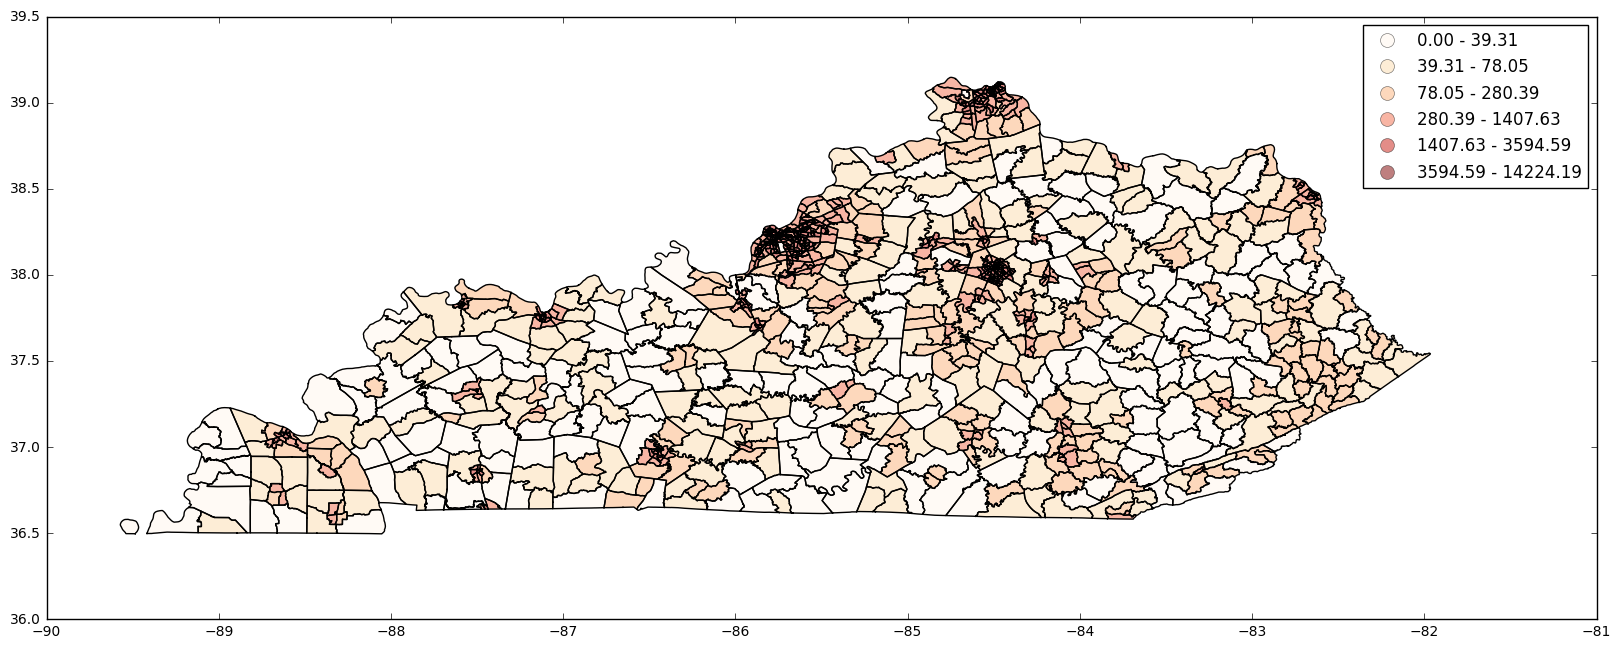

In [38]:
area_to_tract.plot(column='density', scheme='QUANTILES', k=6, cmap='OrRd', legend=True, figsize=(20, 20))